### Matrix Factorization with Regularization

#### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, KFold
import time
from scipy.stats import spearmanr
import statsmodels.formula.api as sm

#### Import Data

In [2]:
ratings = pd.read_csv('../../ratings.csv')

#### Make Subsets of Data for Part I

In [3]:
def pick_users_books(df, num_users, num_books):
    user_counts = pd.DataFrame(df.user_id.value_counts()).sort_values('user_id', ascending=False)
    top_10K_users = list(user_counts[0:num_users].index)
    user_filtered_df = df[df.user_id.isin(top_10K_users)]
    filtered_book_counts = pd.DataFrame(user_filtered_df.book_id.value_counts()).sort_values('book_id', 
                                                                                             ascending = False)
    top_100_filtered_books = list(filtered_book_counts[0:num_books].index)
    filtered_df = user_filtered_df[user_filtered_df.book_id.isin(top_100_filtered_books)]
    train, test = train_test_split(filtered_df, test_size = 0.2, random_state=42)
    return train, test
    
def get_all_subsets(df):
    train_500_20, test_500_20 = pick_users_books(df, 500, 20)
    train_1000_35, test_1000_35 = pick_users_books(df, 1000, 35)
    train_2000_50, test_2000_50 = pick_users_books(df, 2000, 50)
    train_5000_70, test_5000_70 = pick_users_books(df, 5000, 70)
    train_7500_85, test_7500_85 = pick_users_books(df, 7500, 85)
    train_10000_100, test_10000_100 = pick_users_books(df, 10000, 100)
    return train_500_20, test_500_20, train_1000_35, test_1000_35, train_2000_50, test_2000_50, \
        train_5000_70, test_5000_70, train_7500_85, test_7500_85, train_10000_100, test_10000_100

In [4]:
train_500_20, test_500_20, train_1000_35, test_1000_35, train_2000_50, test_2000_50, train_5000_70, test_5000_70, \
    train_7500_85, test_7500_85, train_10000_100, test_10000_100 = get_all_subsets(ratings)

#### Implement Matrix Factorization

In order to implement matrix factorization we need to get the data in a usable format. First, we create user-item matrices for the train and test data. As a bit of a workaround, we create fake data to add to the test set (a row for each user and a row for each book) to make sure that the test matrix is the same size as the train matrix. Then we drop the fake data. Finally, we subtract the mean of each user's ratings.

In [5]:
def preprocess(X_train, X_test):
    
    # create user and book indices starting from 0
    mappings_user = pd.DataFrame({'user_id': sorted(X_train.user_id.unique()), 
                              'user_idx': range(len(X_train.user_id.unique()))})
    mappings_book = pd.DataFrame({'book_id': sorted(X_train.book_id.unique()), 
                              'book_idx': range(len(X_train.book_id.unique()))})
    X_train = pd.merge(X_train, mappings_user, on='user_id')
    X_train = pd.merge(X_train, mappings_book, on='book_id')
    X_test = pd.merge(X_test, mappings_user, on='user_id')
    X_test = pd.merge(X_test, mappings_book, on='book_id')
    
    # create user-item matrix for training data and find non-zero values
    M = np.array(X_train.pivot_table(index = 'user_idx', columns='book_idx', values='rating', fill_value=0))
    mask = M != 0
    
    # use fake data to make test matrix that matches the size of the train matrix
    fake_book = pd.DataFrame({'user_id': sorted(X_train.user_id.unique()), 'rating': 0,
                          'user_idx': range(len(X_train.user_id.unique())), 'book_id': 'XXX', 'book_idx': 100})
    fake_user = pd.DataFrame({'book_id': sorted(X_train.book_id.unique()), 'rating': 0,
                          'book_idx': range(len(X_train.book_id.unique())), 'user_id': 'XXX', 'user_idx': 10000000000})
    X_test = pd.concat([X_test, fake_book, fake_user])
    M_test = X_test.pivot_table(index = 'user_idx', columns='book_idx', values='rating', fill_value=0)
    M_test.drop(100, axis=1, inplace=True)
    M_test.drop(10000000000, axis=0, inplace=True)
    
    # subtract off user means
    means_list = []
    for row in range(M.shape[0]):
        n_ratings = len(np.where(M[row,:] != 0)[0])
        means_list.append(np.sum(M[row,:]) / n_ratings)
    means = np.array(means_list).reshape(-1,1)
    M_norm = (M - means) * mask
    
    return (M_norm, means, np.array(M_test))

At each iteration, the learned matrices get updated according to the following equations:

$U\leftarrow U\left ( 1 - \alpha \lambda  \right ) + \alpha EV$  
$V\leftarrow V\left ( 1 - \alpha \lambda  \right ) + \alpha E^{T}U$

In [27]:
def update(R, mask, U, V, alpha, E, lamb): # performs one iteration of updating U and V matrices
    U_new = (U * (1 - (alpha * lamb))) + (alpha * np.dot(E, V))
    V_new = (V * (1 - (alpha * lamb))) + (alpha * np.dot(E.transpose(), U))
    return (U_new, V_new)

In [7]:
def calc_error(R, mask, U, V): 
    # calculates error matrix - difference between prediction and true rating where true rating exists, 0 otherwise
    E = (R - np.dot(U, V.transpose())) * mask
    return E

The objective function is minimized according to the following equation:

$J = \frac{1}{2} \sum_{(i,j)\in S} e_{ij}^{2} \: + \frac{\lambda }{2} \sum_{i=1}^{m} \sum_{s=1}^{k} u_{is}^{2} \: + \frac{\lambda }{2} \sum_{j=1}^{n} \sum_{s=1}^{k} v_{js}^{2}$

where m is the number of users, n is the number of items, k is the rank, and $\lambda$ is the regularization parameter. The first term minimizes squared error between the predictions and ratings, while the second and third terms penalize large values to prevent overfitting.

In [8]:
def calc_loss(E, U, V, lamb): # calculate value of loss function based on error matrix
    J = (0.5 * np.sum(np.square(E))) + ((lamb/2) * np.sum(np.square(U))) + ((lamb/2) * np.sum(np.square(V)))
    return J

In [9]:
def mat_fact(R, d, alpha, lamb):
    # initialize U and V
    U = np.random.randn(R.shape[0], d)
    V = np.random.randn(R.shape[1], d)
    
    # calculate error and loss
    mask = R != 0
    E = calc_error(R, mask, U, V)
    J_prev = calc_loss(E, U, V, lamb)
    J_ratio = 1
    
    # while not converged, update U and V and recalculate error and loss
    count = 0
    while np.abs(J_ratio) > .00001:
        if count > 1000 and J_prev > 10000:
            print('Did not converge!')
            return (U, V)
        else:
            U, V = update(R, mask, U, V, alpha, E, lamb)
            E = calc_error(R, mask, U, V)
            J = calc_loss(E, U, V, lamb)
            J_ratio = (J_prev - J) / J_prev
            J_prev = J
            count += 1
            
    return (U, V)

In [10]:
def calc_RMSE(M_test, preds): # calculate RMSE using only observed entries
    mask_test = M_test != 0
    preds_masked = mask_test * preds
    rmse = np.sqrt(np.sum(np.sum(np.square(preds_masked - M_test))) / np.sum(np.sum(mask_test)))
    return rmse

#### Grid-Search Parameters

We grid-searched three parameters:
- rank d at values 5, 10, 15
- learning rate $\alpha$ at values 0.00005, 0.0001, 0.00015, 0.0002
- regularization parameter $\lambda$ at values 0.00001, 0.0001, 0.001, 0.01, 0.1, 1

In [11]:
# d_values = [5, 10, 15]
# alpha_values = [0.00005, 0.0001, 0.00015, 0.0002]
# lamb_values = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

In [12]:
# def overall(data, d, alpha, lamb):
#     k_fold = KFold(n_splits=3)
#     rmses = []
#     for train_indices, test_indices in k_fold.split(data):
#         X_train = data.iloc[train_indices]
#         X_test = data.iloc[test_indices]
#         M_norm, means, X_test = preprocess(X_train, X_test)
#         U, V = mat_fact(M_norm, d, alpha, lamb)
#         preds = np.dot(U, V.transpose()) + means
#         rmse = calc_RMSE(X_test, preds)
#         rmses.append(rmse)
#     return np.mean(rmses)

In [13]:
# grid_results_all = []
# for d in d_values:
#     print('Current d value: ', d)
#     for alpha in alpha_values:
#         print('Current alpha value: ', alpha)
#         for lamb in lamb_values:
#             print('Current lambda value: ', lamb)
#             grid_results = {}
#             rmse = overall(train_10000_100, d, alpha, lamb)
#             grid_results['d'] = d
#             grid_results['alpha'] = alpha
#             grid_results['lambda'] = lamb
#             grid_results['rmse'] = rmse
#             grid_results_all.append(grid_results)

In [14]:
# grid_df = pd.DataFrame(grid_results_all)
# grid_df
# grid_results.to_csv('mat-fact-grid-results.csv')

In [15]:
# min_values = grid_df.iloc[grid_df['rmse'].idxmin()]
# print('The best parameters were d = {}, alpha = {}, and lambda = {}, with an average RMSE of {}.'
#       .format(min_values['d'], min_values['alpha'], min_values['lambda'], min_values['rmse']))

The optimal parameters were d = 5.0, alpha = 0.0001, and lambda = 0.001, with an average RMSE of 0.9581215576515847.

In [5]:
grid_results = pd.read_csv('mat-fact-grid-results.csv')# grid search results

grid_results.sort_values('rmse')

,Unnamed: 0,alpha,d,lambda,rmse
8,8,0.00010,5,0.00100,0.958122
7,7,0.00010,5,0.00010,0.958401
0,0,0.00005,5,0.00001,0.958472
4,4,0.00005,5,0.10000,0.958490
20,20,0.00020,5,0.00100,0.958499
12,12,0.00015,5,0.00001,0.958538
16,16,0.00015,5,0.10000,0.958550
14,14,0.00015,5,0.00100,0.958565
21,21,0.00020,5,0.01000,0.958568
2,2,0.00005,5,0.00100,0.958571


#### Plot Grid-Search Results

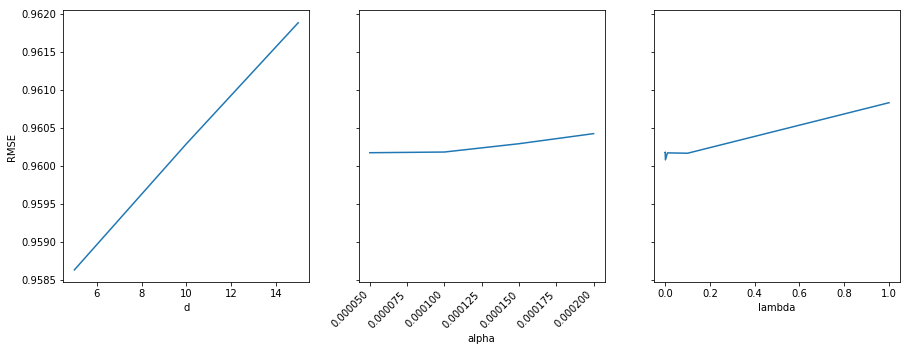

In [17]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(15,5))
ax[0].plot(grid_results.groupby('d')['rmse'].mean())
ax[1].plot(grid_results.groupby('alpha')['rmse'].mean())
ax[2].plot(grid_results.groupby('lambda')['rmse'].mean())
ax[0].set_ylabel('RMSE')
ax[0].set_xlabel('d')
ax[1].set_xlabel('alpha')
ax[2].set_xlabel('lambda')
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment('right')
plt.show()

We can see that changnig d has the greatest effect on RMSE - differences in alpha and lambda were small relative to those in d. From now on, we will use the optimal parameters to train our models.

#### Train Six Subsets to Observe Scalability

In order to see how our model would scale up to a bigger dataset, we see how it performs on different-sized subsets, from ~4300 ratings to ~270000.

In [18]:
def calc_MAE(M_test, preds): # calculate MAE using only observed entries
    mask_test = M_test != 0
    preds_masked = mask_test * preds
    mae = np.sum(np.sum(np.abs(preds_masked - M_test))) / np.sum(np.sum(mask_test))
    return mae

In [19]:
def calc_spearman(M_test, preds): # calculate spearman coefficient using only observed entries
    spearmans = []
    dict_ratings = {}
    # only include values that exist in test data
    for i in range(M_test.shape[0]):
        for j in range(M_test.shape[1]):
            if M_test[i,j] != 0 and float(M_test[i,j]):
                if i in dict_ratings.keys():
                    dict_ratings[i][0].append(M_test[i,j])
                    dict_ratings[i][1].append(preds[i,j])
                else:
                    dict_ratings[i] = [[M_test[i,j]], [preds[i,j]]]
    for i in dict_ratings.keys():
        if len(dict_ratings[i][0]) > 1:
            spearman = spearmanr(dict_ratings[i][0], dict_ratings[i][1])[0]
            if np.isnan(spearman) == False: # spearman is NaN if all true ratings are the same! exclude these
                spearmans.append(spearman)
    return np.mean(spearmans)

In [20]:
def calc_coverage(M_norm, preds, k): # calculate coverage for top k items
    items_covered = []
    mask = M_norm == 0 # don't include items that are already rated
    preds_antitest = preds * mask
    for i in range(preds.shape[0]): # for each user, get the top k predictions
        row = preds[i,:]
        top_idx = np.argsort(row)[::-1]
        [items_covered.append(top_idx[j]) for j in range(k)]
    n_unique_items = len(set(items_covered)) # get the number of unique items recommended
    coverage = n_unique_items / preds.shape[1]
    return coverage

In [21]:
def train_test(X_train, X_test, coverage=False):
    M_norm, means, M_test = preprocess(X_train, X_test)
    start_train = time.time()
    U, V = mat_fact(M_norm, 5, 0.0001, 0.001)
    end_train = time.time()
    start_pred = time.time()
    preds = np.dot(U, V.transpose()) + means
    end_pred = time.time()
    rmse = calc_RMSE(M_test, preds)
    mae = calc_MAE(M_test, preds)
    spearman = calc_spearman(M_test, preds)
    if coverage:
        coverages = []
        for k in [5, 10, 20]:
            coverage_k = calc_coverage(M_norm, preds, k)
            coverages.append(coverage_k)
    else:
        coverages=None
    train_time = end_train - start_train
    pred_time = end_pred - start_pred
    return (train_time, pred_time, rmse, mae, spearman, coverages)

In [22]:
subsets = [(train_500_20, test_500_20, 500, 20, False), (train_1000_35, test_1000_35, 1000, 35, False), 
           (train_2000_50, test_2000_50, 2000, 50, False), (train_5000_70, test_5000_70, 5000, 70, False),
           (train_7500_85, test_7500_85, 7500, 85, False), (train_10000_100, test_10000_100, 10000, 100, True)]

In [23]:
scalability_all = []
for (X_train, X_test, n_users, n_items, coverage) in subsets:
    scalability = {}
    train_time, pred_time, rmse, mae, spearman, coverages = train_test(X_train, X_test, coverage)
    scalability['Number of Users'] = n_users
    scalability['Number of Items'] = n_items
    scalability['Time to Train'] = train_time
    scalability['Time to Predict'] = pred_time
    scalability['RMSE'] = rmse
    scalability['MAE'] = mae
    scalability['Spearman'] = spearman
    if coverages:
        scalability['Coverage-5'] = coverages[0]
        scalability['Coverage-10'] = coverages[1]
        scalability['Coverage-20'] = coverages[2]
    scalability_all.append(scalability)

In [10]:
scalability_df = pd.DataFrame(scalability_all)
scalability_df['Number of Ratings'] = [4311, 13932, 37100, 112959, 187770, 271422]
scalability_df.to_csv('mat-fact-scalability.csv')
scalability_df

,Unnamed: 0,Coverage-10,Coverage-20,Coverage-5,MAE,Number of Items,Number of Users,RMSE,Spearman,Time to Predict,Time to Train,Number of Ratings
0,0,NaN,NaN,NaN,0.730837,20,500,0.945365,-0.013541,0.000046,0.088244,4311
1,1,NaN,NaN,NaN,0.742816,35,1000,0.970255,-0.014656,0.000145,0.135607,13932
2,2,NaN,NaN,NaN,0.740222,50,2000,0.956669,-0.002961,0.000435,0.185009,37100
3,3,NaN,NaN,NaN,0.722442,70,5000,0.931543,-0.012970,0.002242,0.443478,112959
4,4,NaN,NaN,NaN,0.736918,85,7500,0.944203,0.008806,0.004868,0.937093,187770
5,5,0.88,0.99,0.77,0.739356,100,10000,0.949053,-0.003703,0.009279,1.130002,271422


#### Plot Results

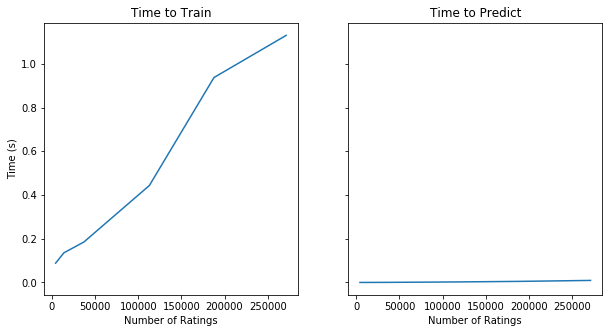

In [25]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax[0].plot(scalability_df['Number of Ratings'], scalability_df['Time to Train'])
ax[1].plot(scalability_df['Number of Ratings'], scalability_df['Time to Predict'])
ax[0].set_ylabel('Time (s)')
ax[0].set_xlabel('Number of Ratings')
ax[1].set_xlabel('Number of Ratings')
ax[0].set_title('Time to Train')
ax[1].set_title('Time to Predict')
plt.show()

As we can see, while the time it takes to train scales roughly linearly with the number of ratings, the time to predict remains about the same. Based on these data, we can predict how long it would take to train a model with the full dataset. First, we calculate the parameters for a linear regression.

In [49]:
time_reg = scalability_df[['Time to Train', 'Number of Ratings']]
time_reg.columns = ['time', 'ratings']

result = sm.ols(formula="time ~ ratings", data=time_reg).fit()
print(result.params)

Intercept    0.057419
ratings      0.000004
dtype: float64


The resulting equation is:
$time = (0.057419 * #ratings) + 0.000004$

In [52]:
print('The estimated time for the full dataset would be {} seconds.'.format((0.057419*5976479) + 0.000004))

The estimated time for the full dataset would be 343163.44770499994 seconds.


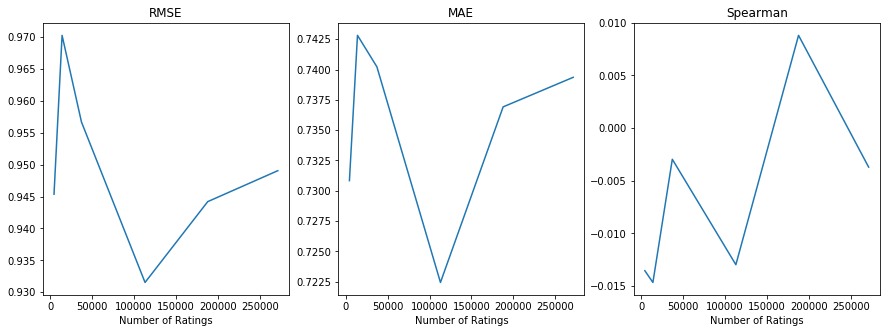

In [26]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(scalability_df['Number of Ratings'], scalability_df['RMSE'])
ax[1].plot(scalability_df['Number of Ratings'], scalability_df['MAE'])
ax[2].plot(scalability_df['Number of Ratings'], scalability_df['Spearman'])
ax[0].set_xlabel('Number of Ratings')
ax[1].set_xlabel('Number of Ratings')
ax[2].set_xlabel('Number of Ratings')
ax[0].set_title('RMSE')
ax[1].set_title('MAE')
ax[2].set_title('Spearman')
plt.show()

Both RMSE and MAE have minima on a medium-sized dataset (and have similar shapes otherwise). Both errors would be expected to increase monotonically as the data gets more sparse, so it is not clear what is causing this pattern, whether reproducible or simply a random artifact of the data itself.

#### Coverage

Coverage measures the fraction of items that get recommended among the top k items for at least one user. For k=5,10,20 the coverage values were 0.77, 0.88, and 0.99. This model achieved very high coverage, and thus demonstrates an ability to recommend quite a wide array of products, although it is important to remember that the dataset we are dealing with is exclusively for popular items.